# Artificial Neural Network for stable points

## Import libraries and preprocessing

In [1]:
# read & manipulate data
import keras_tuner as kt
import os
import numpy as np
import pandas as pd 
import random as rn
import sys
sys.path.append("../scripts")
import tensorflow as tf
import utils
import warnings

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

RANDOM_SEED = 420
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
tf.config.set_visible_devices([], 'GPU') # Disable GPU since slow on my machine
tf.config.threading.set_inter_op_parallelism_threads(8)

In [2]:
# Model paths
pkl_path = '/Users/junxingli/Desktop/master_thesis/data/processed/SRD_Lysekil.pkl'
tuner_path = '/Users/junxingli/Desktop/master_thesis/models/ann/'
proj_name = 'stationary-whole-V3/'
best_model_path = tuner_path + proj_name + 'best_model'

# Figure paths
overwrite = False
figs_path = '/Users/junxingli/Desktop/master_thesis/figs/ann/'
plots_path = figs_path + proj_name

In [3]:
df = pd.read_pickle("../data/processed/SRD_Lysekil.pkl")
df = df[df['Status'] == 'Stable']

X = df.drop(['Status', 'SRD', 'T5'], axis=1)
y = df[['Time', 'SRD']]

#date = "2020-06-15 00:00"
#X_train = X[X["Time"] < date].copy()
#X_test = X[X["Time"] > date].copy()
#y_train = y[y["Time"] < date].copy()
#y_test = y[y["Time"] > date].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standard scaling the data
scaler = StandardScaler()
cols = [col for col in X_train.columns if col != 'Time']
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

# Need to reshape since the scaler expects a 2D array
y_train['SRD'] = scaler.fit_transform(y_train['SRD'].to_numpy().reshape(-1, 1))
y_test['SRD'] = scaler.transform(y_test['SRD'].to_numpy().reshape(-1, 1))

input_dim = X.drop('Time', axis=1).shape[1]
output_dim = y.drop('Time', axis=1).shape[1]

## Simple ANN with zero hidden layers

In [ ]:
def buildModel(optimizer='adam'):
    classifier = Sequential()

    classifier.add(Input(shape=(input_dim,)))    
    #classifier.add(Dense(units=128, activation='relu'))
    #classifier.add(Dense(units=128, activation='relu'))
    classifier.add(Dense(units=1, activation='linear'))
    
    classifier.compile(loss='mean_squared_error', 
                  optimizer=optimizer, 
                  metrics=['mean_squared_error'])
    
    return classifier

regressor = buildModel('adam')
History = regressor.fit(x=X_train.drop('Time', axis=1), 
                        y=y_train.drop('Time', axis=1),
                        batch_size=32, 
                        epochs=100, 
                        verbose=0)

In [ ]:
first_layer_weights = regressor.layers[0].get_weights()[0]

df = pd.DataFrame({'Feature': X.drop('Time', axis=1).columns,
                   'Coefficient': first_layer_weights.flatten()})

fig = go.Figure(data=[go.Bar(x=df['Feature'], y=df['Coefficient'])])  

fig.update_layout(
                xaxis_title="Feature",
                yaxis_title="Coefficient",
                height=400,
                width=800,
                legend=dict(
                            orientation="h",
                            yanchor="bottom",
                            y=1.02,
                            xanchor="right",
                            x=0.15
                        ),
                template="seaborn",
                margin=dict(l=0, r=20, t=20, b=10),
                )

In [ ]:
plt.plot(History.history['mean_squared_error'])
plt.title('Loss Function Over Epochs')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.show()

In [ ]:
def plot_results(df_res):
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=df_res["Time"], 
            y=df_res["Actual"], 
            mode='markers', 
            marker=dict(size=4),
            name='Actual',
        )
    )

    fig.add_trace(
        go.Scatter(
            x=df_res["Time"], 
            y=df_res["Predicted"], 
            mode='markers', 
            marker=dict(size=4),
            name='Prediction',
        )
    )

    fig.update_layout(title="Modelling the SRD using ANN", 
                    legend=dict(
                            orientation="h",
                            yanchor="bottom",
                            y=1.02,
                            xanchor="right",
                            x=0.3
                        ),
                    template="seaborn",
                    xaxis_title="Time", 
                    yaxis_title="Specific Reboiler Duty [MJ/kgCO2]")

    fig.show()

def prediction_df(model, scaler, X, y):
    y_pred = model.predict(X.drop('Time', axis=1))
    y_pred = scaler.inverse_transform(y_pred)
    
    y_inv = y.copy()
    y_inv['SRD'] = scaler.inverse_transform(y['SRD'].to_numpy().reshape(-1, 1))

    df_res = pd.DataFrame({'Time': y_inv['Time'], 
                           'Actual': y_inv['SRD'], 
                           'Predicted': y_pred.flatten()})
    df_res.sort_values('Time')
    
    rmse = mean_squared_error(df_res['Actual'], df_res['Predicted'], squared=False)
    print(f"Root Mean Squared Error: {rmse}")
    
    return df_res

In [ ]:
df_train = prediction_df(regressor, scaler, X_train, y_train)
df_test = prediction_df(regressor, scaler, X_test, y_test)
#plot_results(df_res)

# Using Keras Tuner

WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.

WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.

In [4]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp): 
        hp_layers = hp.Int('num_layers', 3, 5)
        #hp_normal = hp.Boolean('normalization', default=False)
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])
        hp_optimizer = hp.Choice('optimizer', values=['adam', 'SGD', 'rmsprop'])
            
        model = keras.Sequential()
        model.add(Input(shape=(input_dim,)))
        for i in range(hp_layers):
            hp_nodes = hp.Int('num_nodes_'+str(i), min_value=50, max_value=150, step=5)
            hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
            hp_dropout = hp.Boolean('dropout-normalization', default=False)
            
            model.add(Dense(units=hp_nodes, activation=hp_activation))
            if hp_dropout:
                model.add(Dropout(rate=0.25))
                model.add(BatchNormalization())
        
        model.add(Dense(1, activation='linear'))
        
        # Select optimizer    
        optimizer_dict = {
            'adam': keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate),
            'SGD': keras.optimizers.legacy.SGD(learning_rate=hp_learning_rate),
            'rmsprop': keras.optimizers.legacy.RMSprop(learning_rate=hp_learning_rate)
        }
        model.compile(
            optimizer=optimizer_dict[hp_optimizer],
            loss='mean_squared_error',
            metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error']
        )
        
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32, 64, 128]),
            **kwargs,
        )

In [5]:
tuner = kt.Hyperband(
    MyHyperModel(),
    objective='val_mean_squared_error',
    max_epochs=1000,
    overwrite=False,
    directory=tuner_path,
    project_name=proj_name)

reduce_lr = ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.2,
                              patience=5, min_lr=0.001)

stop_early = EarlyStopping(monitor='val_mean_squared_error', 
                                              patience=50)

tuner.search(X_train.drop('Time', axis=1),
             y_train.drop('Time', axis=1), 
             epochs=1000, 
             validation_split=0.25, 
             callbacks=[stop_early, reduce_lr])

Reloading Tuner from /Users/junxingli/Desktop/master_thesis/models/ann/stationary-whole-V3/tuner0.json


In [13]:
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs=None):
        x, y = self.test_data
        results = self.model.evaluate(x, y, verbose=0)
        logs['test_mse'] = results if isinstance(results, float) else results[1]
        print('\nTest MSE:', logs['test_mse'])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='mean_squared_error', factor=0.2,
                              patience=5, min_lr=0.001)

stop_early = EarlyStopping(monitor='mean_squared_error', 
                                              patience=20)

test_callback = TestCallback((X_test.drop('Time', axis=1), 
                              y_test.drop('Time', axis=1)))

# Fit the model and save the best model
History = best_model.fit(X_train.drop('Time', axis=1), 
                         y_train.drop('Time', axis=1), 
                         epochs=60, 
                         callbacks=[stop_early, reduce_lr, test_callback],
                         validation_split=0)

best_model.summary()
print(best_hps.values)

Epoch 1/60
259/299 [========================>.....] - ETA: 0s - loss: 0.2784 - mean_squared_error: 0.2784 - mean_absolute_error: 0.3196 - mean_absolute_percentage_error: 254.4340
Test MSE: 0.16104097664356232
299/299 [==============================] - 1s 1ms/step - loss: 0.2617 - mean_squared_error: 0.2617 - mean_absolute_error: 0.3190 - mean_absolute_percentage_error: 256.8105 - lr: 0.0010 - test_mse: 0.1610
Epoch 2/60
296/299 [============================>.] - ETA: 0s - loss: 0.2455 - mean_squared_error: 0.2455 - mean_absolute_error: 0.3007 - mean_absolute_percentage_error: 251.8982
Test MSE: 0.14844785630702972
299/299 [==============================] - 0s 1ms/step - loss: 0.2447 - mean_squared_error: 0.2447 - mean_absolute_error: 0.3009 - mean_absolute_percentage_error: 250.9830 - lr: 0.0010 - test_mse: 0.1484
Epoch 3/60
291/299 [============================>.] - ETA: 0s - loss: 0.2413 - mean_squared_error: 0.2413 - mean_absolute_error: 0.2959 - mean_absolute_percentage_error: 290.

Model file already exists at /Users/junxingli/Desktop/master_thesis/models/ann/stationary-whole-V3/best_model. Set 'overwrite=True' to overwrite the file.
File Loss_over_epoch.pdf already exists at /Users/junxingli/Desktop/master_thesis/figs/ann/stationary-whole-V3/Loss_over_epoch.pdf. Set 'overwrite=True' to overwrite the file.


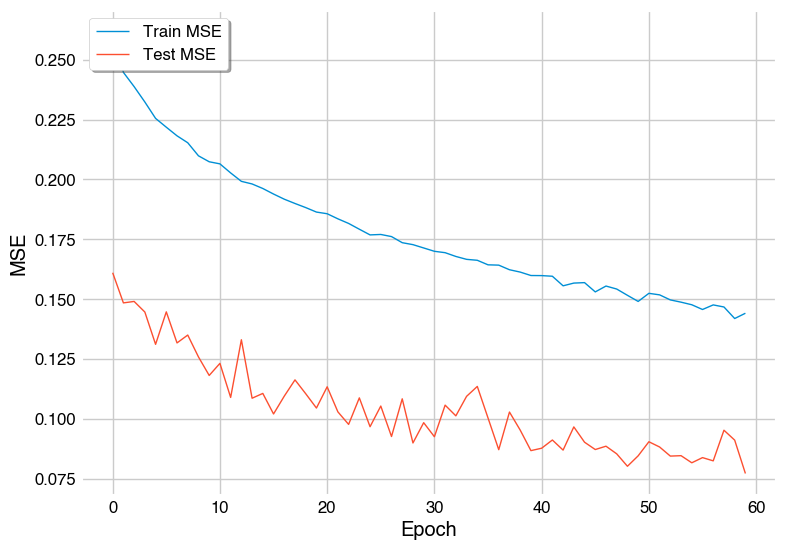

In [14]:
if overwrite or not os.path.exists(best_model_path):
    print(f"Model was saved to {best_model_path}")
    best_model.save(best_model_path)
else:
    print(f"Model file already exists at {best_model_path}. Set 'overwrite=True' to overwrite the file.")
    
utils.plot_mse_over_epochs(History, plots_path, overwrite)

In [15]:
loaded_model = keras.models.load_model(best_model_path)
df_train, rmse_train, r2_train = utils.generate_prediction_df(loaded_model, scaler, X_train, y_train)
df_test, rmse_test, r2_test = utils.generate_prediction_df(loaded_model, scaler, X_test, y_test)

#utils.plot_time_predictions(df_train, df_test, plots_path, overwrite)

299/299 [==============================] - 0s 391us/step
Root Mean Squared Error: 0.08443974635333329
R2 Score: 0.504977009228725
75/75 [==============================] - 0s 383us/step
Root Mean Squared Error: 0.07612034236108399
R2 Score: 0.53051745632882


/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

File Parity_plot_ANN.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/ann/stationary-whole-V3/Parity_plot_ANN.pdf.


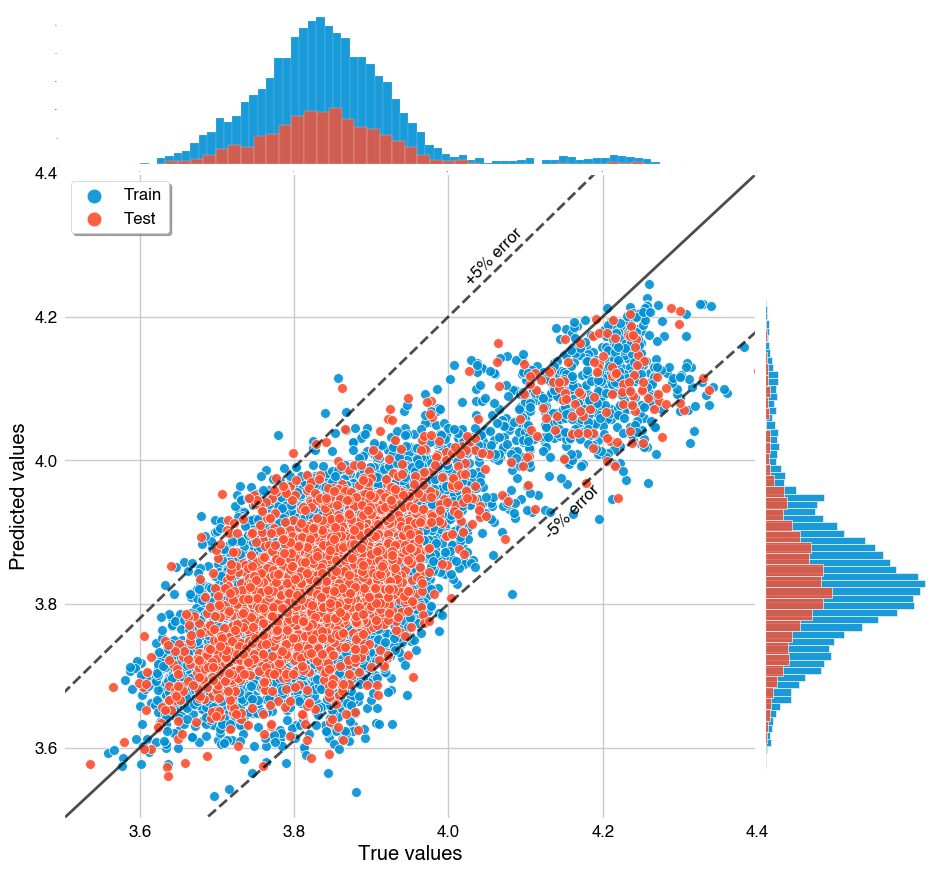

/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


File Residuals_plot_ANN.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/ann/stationary-whole-V3/Residuals_plot_ANN.pdf.


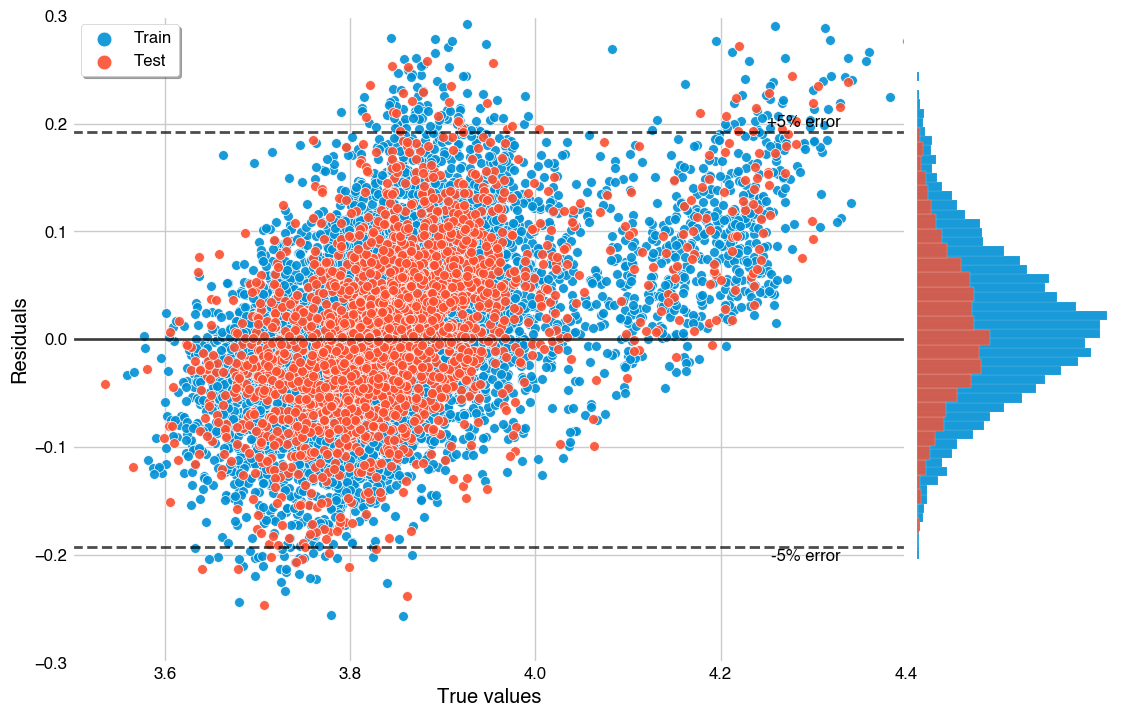

/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

File KDE_plot_ANN.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/ann/stationary-whole-V3/KDE_plot_ANN.pdf.


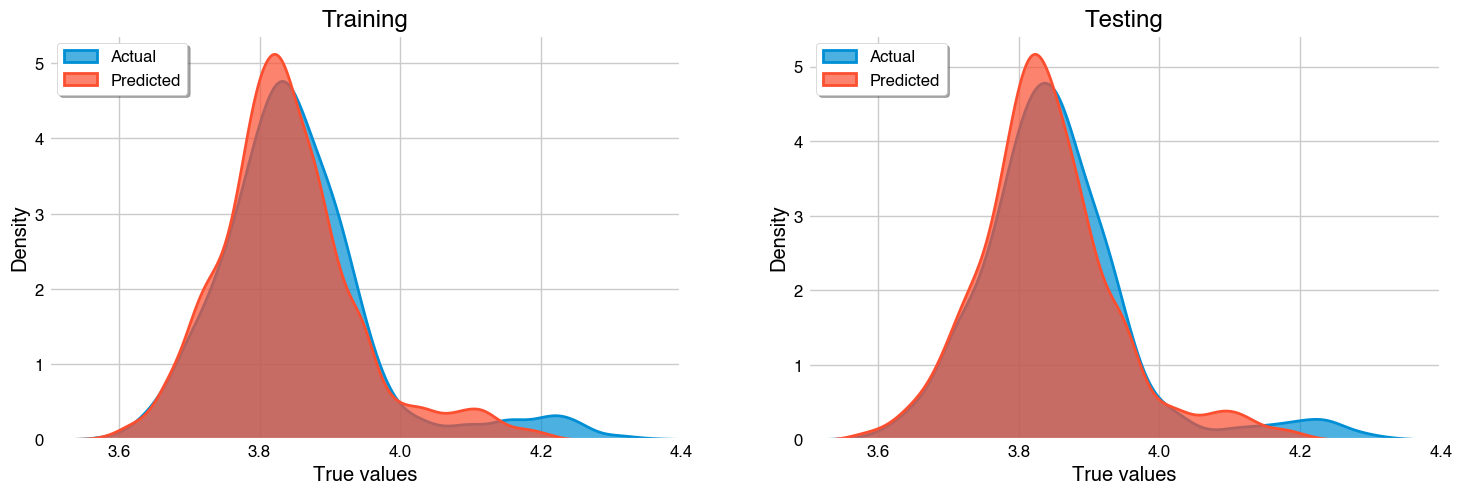

In [17]:
utils.make_evaluation_plots(df_train,
                            df_test,
                            "ANN",
                            plots_path, 
                            overwrite=False, 
                            limit=[3.5, 4.4], 
                            error_line=0.05, 
                            res_limit=[-0.3, 0.3], 
                            mean=df['SRD'].mean())